# Animal shelter outcome

In [1]:
import os
import sys
import re

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn import linear_model, datasets, metrics
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
import seaborn as sns

In [2]:
train=pd.read_csv('train.csv')
print(train.columns.values)
(train.head(5))

['AnimalID' 'Name' 'DateTime' 'OutcomeType' 'OutcomeSubtype' 'AnimalType'
 'SexuponOutcome' 'AgeuponOutcome' 'Breed' 'Color']


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


# Visualize data

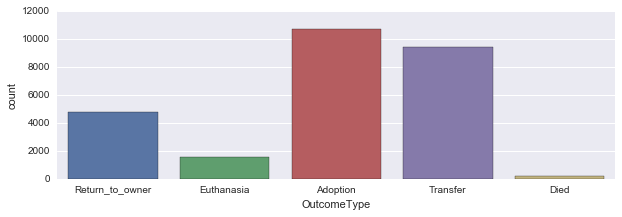

In [3]:
#f, axarr = plt.subplot( figsize=(15, 5))
fig, ax = plt.subplots(figsize=(10, 3))
sns.countplot(x="OutcomeType", data=train,ax=ax)



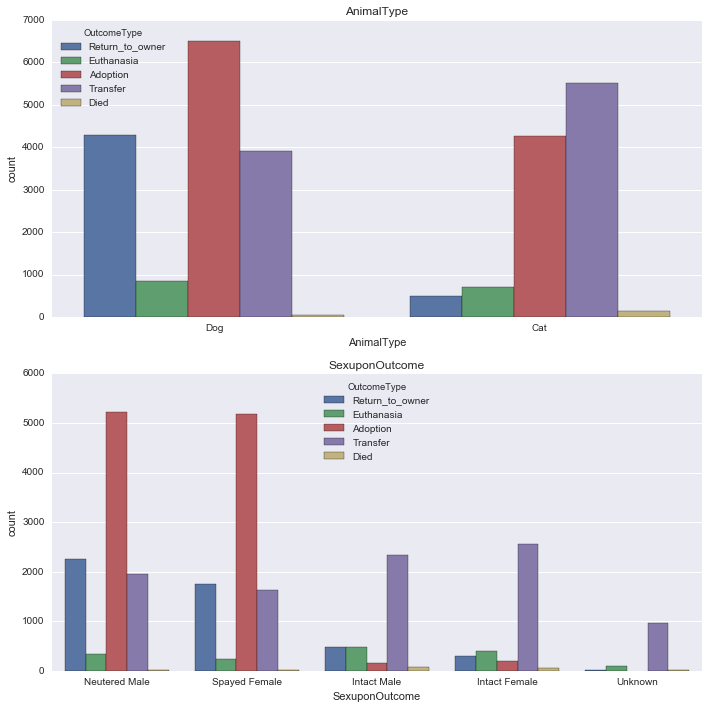

In [4]:
fig, axarr = plt.subplots(2,figsize=(10, 10))

sns.countplot(x="AnimalType", hue="OutcomeType", data=train, ax=axarr[0])
sns.countplot(x="SexuponOutcome", hue="OutcomeType", data=train, ax=axarr[1])
#sns.countplot(x="Color", hue="OutcomeType", data=train, ax=axarr[1])

axarr[0].set_title('AnimalType')
axarr[1].set_title('SexuponOutcome')

plt.tight_layout()
plt.show()

In [5]:
print(train['Breed'].nunique())
print(train['Color'].nunique())
print(train['Name'].nunique())

print(len(train))

1380
366
6374
26729


# Create our own features

In [6]:
def get_age(string,x):
    return float(str(x).split(" ")[0]) if str(x).split(" ")[1].startswith(string) else 0


In [119]:
dummies_var=['Breed','Color','SexuponOutcome','AnimalType','OutcomeSubtype','OutcomeType']
def corr_df(train):
    newdf=pd.get_dummies(train[dummies_var], prefix=dummies_var)
    date=pd.DataFrame([])
    date_labels=[["year",0,0,"-"],["month",0,1,"-"],["dayOfMonth",0,2,"-"],["hour",1,0,":"],["minute",1,1,":"]]
    #create labels for the dates
    for label in date_labels:
        date[label[0]]=train['DateTime'].map(lambda x:int(x.split(" ")[label[1]].split(label[3])[label[2]]))
    date["minuteOfDay"]=date["hour"]*60+date["minute"]
    #print(newdf["minuteOfDay"])
    date.drop('hour',axis=1, inplace=True)
    date.drop('minute',axis=1, inplace=True)

    #newdf=pd.concat([newdf,pd.get_dummies(date.astype(str), prefix=date.columns.values)],axis=1)
    newdf=pd.concat([newdf,date],axis=1)
    
    age=pd.DataFrame([])
    age_labels=["year","month","week","day","unknown"]
    for label in age_labels:
        age[label]=train['AgeuponOutcome'].fillna("1 unknown").map(lambda x:get_age(label,x))
    newdf["age_unknown"]=age["unknown"]
    newdf["age"]=age["year"]*365+age["month"]*30+age["week"]*7+age["day"]
    #newdf=pd.concat([newdf,pd.get_dummies(age, prefix=age.columns.values)],axis=1)
    newdf['OutcomeType']=train['OutcomeType']
    return newdf

In [120]:
corr_train=corr_df(train)
corr_train.head(5)

,Breed_Abyssinian Mix,Breed_Affenpinscher Mix,Breed_Afghan Hound Mix,Breed_Airedale Terrier,Breed_Airedale Terrier Mix,Breed_Airedale Terrier/Labrador Retriever,Breed_Airedale Terrier/Miniature Schnauzer,Breed_Akita,Breed_Akita Mix,Breed_Akita/Australian Cattle Dog,...,OutcomeType_Euthanasia,OutcomeType_Return_to_owner,OutcomeType_Transfer,year,month,dayOfMonth,minuteOfDay,age_unknown,age,OutcomeType
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2014,2,12,1102,0.0,365.0,Return_to_owner
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2013,10,13,764,0.0,365.0,Euthanasia
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2015,1,31,748,0.0,730.0,Adoption
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2014,7,11,1149,0.0,21.0,Transfer
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2013,11,15,772,0.0,730.0,Transfer


In [81]:
corr_train.columns.values

array(['Breed_Abyssinian Mix', 'Breed_Affenpinscher Mix',
       'Breed_Afghan Hound Mix', ..., 'age_unknown', 'age', 'OutcomeType'], dtype=object)

In [70]:
train["OutcomeType"].unique()

array(['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died'], dtype=object)

## Visualize the new data

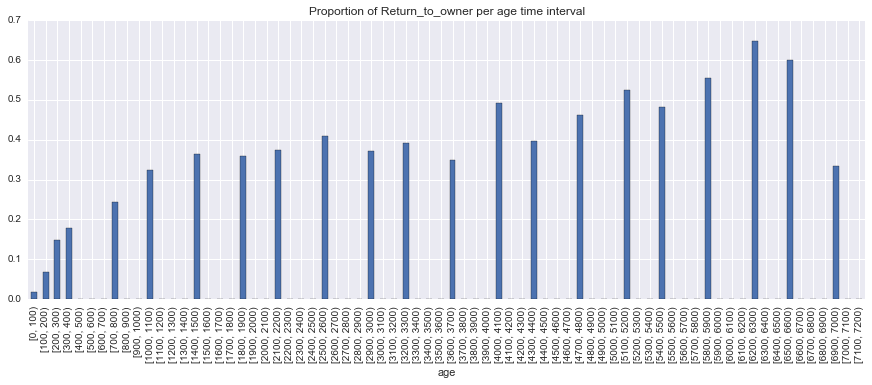

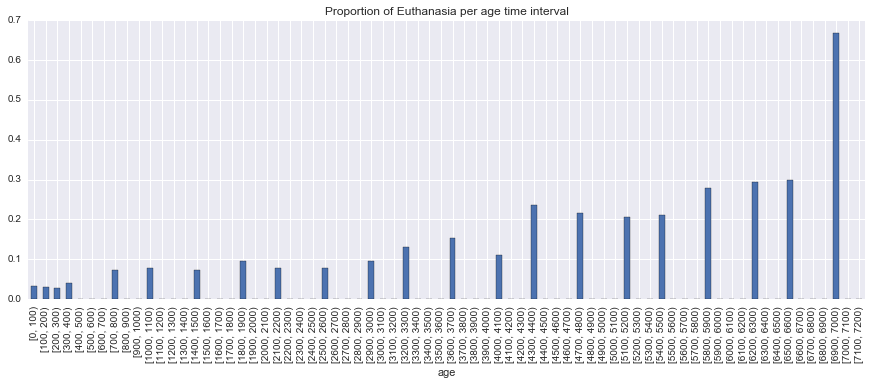

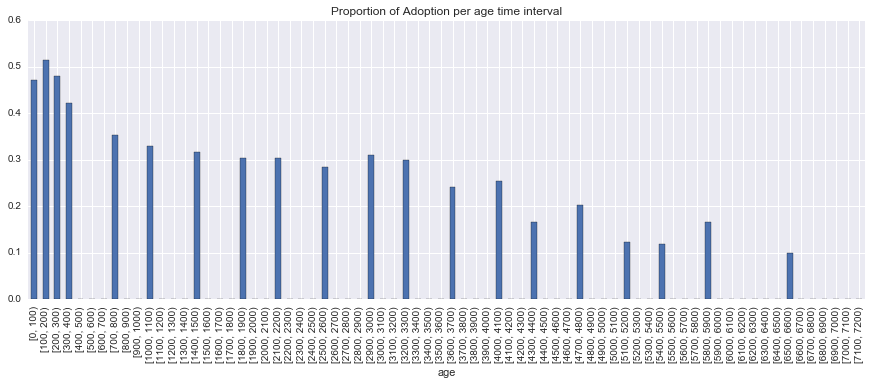

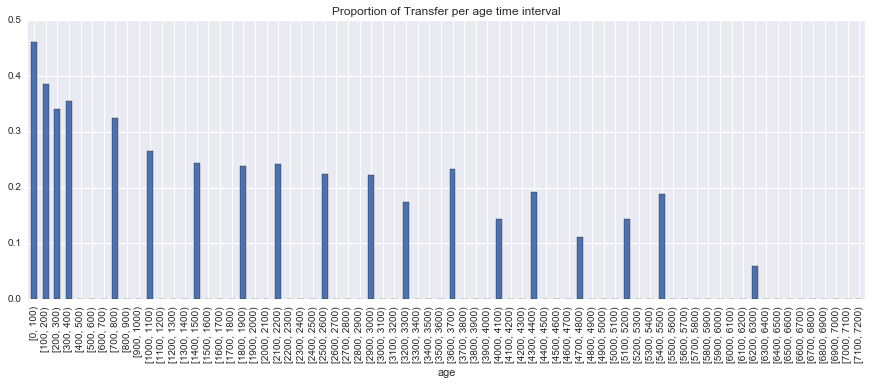

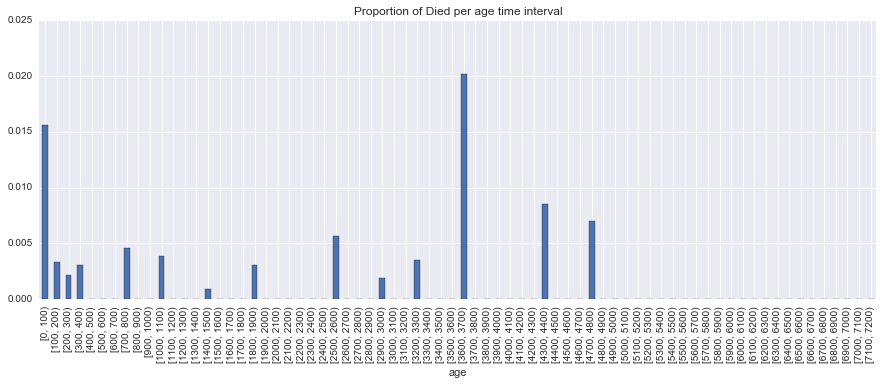

In [38]:

for category in train["OutcomeType"].unique():
    #category="Euthanasia"
    time_bins = np.arange(0,max(corr_train['age'].unique()) , 100)
    outcomes_in_time = pd.cut(corr_train['age'], time_bins, right=False)
    grouped=corr_train.groupby(outcomes_in_time)
    counts=(grouped['Month'+category].sum()/grouped['OutcomeType'].count())
    plt.title("Proportion of "+category+" per age time interval")

    counts.plot(kind='bar',figsize=(15,5))
    plt.show()

# Let's classify

In [72]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()



Y=le.fit_transform(np.asarray(train['OutcomeType']))

input_corr_train=corr_train
for feature in corr_train.columns.values:
    if feature.startswith("Outcome"):
        input_corr_train=input_corr_train.drop(feature, 1) 
X=np.asarray(input_corr_train)

In [73]:
corr_train.describe()

,Breed_Abyssinian Mix,Breed_Affenpinscher Mix,Breed_Afghan Hound Mix,Breed_Airedale Terrier,Breed_Airedale Terrier Mix,Breed_Airedale Terrier/Labrador Retriever,Breed_Airedale Terrier/Miniature Schnauzer,Breed_Akita,Breed_Akita Mix,Breed_Akita/Australian Cattle Dog,...,minuteOfDay_23232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232335,minuteOfDay_23232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232337,minuteOfDay_23232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232338,minuteOfDay_23232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232340,minuteOfDay_23232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232343,minuteOfDay_23232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232353,minuteOfDay_23232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232357,minuteOfDay_23232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232358,age_unknown,age
count,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,...,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000
mean,0.000075,0.000224,0.000037,0.000037,0.000187,0.000037,0.000037,0.000112,0.000412,0.000037,...,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000075,0.000673,793.595982
std,0.008650,0.014981,0.006117,0.006117,0.013676,0.006117,0.006117,0.010594,0.020283,0.006117,...,0.006117,0.006117,0.006117,0.006117,0.006117,0.006117,0.006117,0.008650,0.025942,1082.661580
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,365.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1095.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7300.000000


In [51]:


from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X, Y)
Y_pred=clf.predict(X)

In [58]:
np.mean(Y_pred==Y)

0.17041415690822703